# IMPORTS

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from transformers import CLIPTokenizer, CLIPTextModel, get_scheduler
from PIL import Image
from typing import Optional, List, Tuple
import math
from diffusers import DDPMScheduler, UNet2DConditionModel, AutoencoderKL
import os
import random

c:\Users\anike\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PRE

In [69]:
import shutil

parent_dir = "flowers"

for root, dirs, files in os.walk(parent_dir):
    for file in files:
        file_path = os.path.join(root, file)
        shutil.move(file_path, parent_dir)

In [91]:
images_list = os.listdir('flowers/images')
random.seed(42)
random.shuffle(images_list)

# DATALOADER

In [83]:
class TextImageDataLoader(Dataset):
    def __init__(self, datalist, image_size: Tuple[int, int], max_text_length: int):
        super().__init__()
        self.datalist = datalist
        self.image_size = image_size
        self.max_text_length = max_text_length

        model_name = "openai/clip-vit-base-patch32"  # Or another CLIP model
        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.text_encoder = CLIPTextModel.from_pretrained(model_name).to("cuda")

        # Image preprocessing with normalization
        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    def __len__(self) -> int:
        return len(self.datalist)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get the image and caption filenames
        image_file = self.datalist[idx]
        comment_file = image_file.replace('.jpg', '.txt')  # Assumes consistent naming

        # Load and preprocess the image
        image = Image.open(f'flowers/images/{image_file}').convert("RGB")
        image = self.image_transform(image)

        # Load the text caption
        with open(f'flowers/captions/{comment_file}', 'r') as f:
            text = f.read()

        # Tokenize the text
        tokens = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_text_length,
            return_tensors="pt"
        )
        input_ids = tokens.input_ids.to("cuda")
        attention_mask = tokens.attention_mask.to("cuda")

        # Compute text embeddings
        with torch.no_grad():
            outputs = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_embeddings = outputs.last_hidden_state

        return image, text_embeddings.squeeze(), text


# UNET

In [67]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.dim = dim

    def forward(self, time: torch.Tensor) -> torch.Tensor:
        device = time.device
        half_dim = self.dim // 2
        embeddings = torch.exp(
            torch.arange(half_dim, dtype=torch.float32, device=device) * 
            -(math.log(10000) / (half_dim - 1))
        )
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class AttentionBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.channels = channels
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h)
        q, k, v = qkv.chunk(3, dim=1)
        
        q = q.view(B, C, -1)
        k = k.view(B, C, -1)
        v = v.view(B, C, -1)

        scale = 1.0 / math.sqrt(math.sqrt(C))
        attention = torch.softmax(torch.bmm(q.transpose(1, 2), k) * scale, dim=-1)
        h = torch.bmm(v, attention.transpose(1, 2))
        h = h.view(B, C, H, W)
        return x + self.proj(h)

class ResnetBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_ch)
        self.norm2 = nn.GroupNorm(8, out_ch)
        self.act = nn.SiLU()
        
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.shortcut = nn.Identity()
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = self.conv1(x)
        h = self.act(self.norm1(h))
        h = self.conv2(h)
        h = self.act(self.norm2(h))
        return h + self.shortcut(x)

class ConditionalBlock(nn.Module):
    def __init__(
        self, 
        in_ch: int, 
        out_ch: int, 
        time_emb_dim: int, 
        text_emb_dim: int, 
        up: bool = False,
        attention: bool = False
    ):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, out_ch * 2),
            nn.SiLU(),
            nn.Linear(out_ch * 2, out_ch)
        )
        self.text_mlp = nn.Sequential(
            nn.Linear(text_emb_dim, out_ch * 2),
            nn.SiLU(),
            nn.Linear(out_ch * 2, out_ch)
        )

        self.resnet = ResnetBlock(in_ch, out_ch)
        self.attention = AttentionBlock(out_ch) if attention else nn.Identity()
        
        self.up = up
        if up:
            self.transform = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(out_ch, out_ch, 3, padding=1)
            )
        else:
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

    def forward(self, x: torch.Tensor, t: torch.Tensor, text_emb: torch.Tensor) -> torch.Tensor:
        # Print shapes for debugging
        h = self.resnet(x)
        
        time_emb = self.time_mlp(t)[:, :, None, None]
        text_emb = self.text_mlp(text_emb)[:, :, None, None]
        h = h + time_emb + text_emb
        
        h = self.attention(h)
        h = self.transform(h)
        return h

class TextConditionalUnet(nn.Module):
    def __init__(
        self, 
        max_length: int, 
        channels: List[int],
        attention_resolutions: Optional[List[int]] = None
    ):
        super().__init__()
        image_channels = 3
        down_channels = channels
        up_channels = channels[::-1]
        time_emb_dim = 256
        text_emb_dim = max_length
        
        if attention_resolutions is None:
            attention_resolutions = [len(channels) - 1, len(channels) - 2]

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        # Initial conv
        self.conv0 = ResnetBlock(image_channels, down_channels[0])

        # Downsampling blocks
        self.downs = nn.ModuleList([
            ConditionalBlock(
                down_channels[i], 
                down_channels[i + 1],
                time_emb_dim,
                text_emb_dim,
                attention=(i in attention_resolutions)
            )
            for i in range(len(down_channels) - 1)
        ])

        # Middle blocks
        self.mid = nn.Sequential(
            ResnetBlock(down_channels[-1], down_channels[-1]),
            AttentionBlock(down_channels[-1]),
            ResnetBlock(down_channels[-1], down_channels[-1])
        )

        # Upsampling blocks
        self.ups = nn.ModuleList([
            ConditionalBlock(
                up_channels[i], 
                up_channels[i + 1],
                time_emb_dim,
                text_emb_dim,
                up=True,
                attention=(i in attention_resolutions)
            )
            for i in range(len(up_channels) - 1)
        ])

        # Final convolution block
        self.final = nn.Sequential(
            ResnetBlock(up_channels[-1], up_channels[-1]),
            nn.GroupNorm(8, up_channels[-1]),
            nn.SiLU(),
            nn.Conv2d(up_channels[-1], image_channels, 3, padding=1)
        )

    def forward(self, x: torch.Tensor, t: torch.Tensor, text_emb: torch.Tensor) -> torch.Tensor:
        # Time embedding
        t = self.time_mlp(t)
        
        # Initial convolution
        h = self.conv0(x)

        # Store skip connections
        skips = []
        for down in self.downs:
            skips.append(h)
            h = down(h, t, text_emb)

        # Middle block
        h = self.mid(h)

        # Upsample with skip connections
        for up in self.ups:
            h = up(h, t, text_emb)
            skip = skips.pop()
            # Ensure skip connection has the same spatial dimensions
            if h.shape[-2:] != skip.shape[-2:]:
                skip = F.interpolate(skip, size=h.shape[-2:], mode='nearest')
            h = h + skip  # Changed from concatenation to addition

        return self.final(h)


# TRAINING

In [84]:
torch.set_float32_matmul_precision("medium")

In [105]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# Configuration dictionary
config = {
    'image_size': (64, 64),
    'max_length': 77,

    'train_size': 500,
    'val_size': 50,
    
    'T': 300,

    'unet_image_size': (8, 8),
    'in_channels': 4,
    'out_channels': 4,
    'down_block_types':("CrossAttnDownBlock2D", "CrossAttnDownBlock2D", "DownBlock2D"),
    'up_block_types': ("CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "UpBlock2D"),
    'mid_block_type':"UNetMidBlock2DCrossAttn",
    'block_out_channels': (64, 128, 256),
    'layers_per_block': 2,
    'norm_num_groups': 32,
    'cross_attention_dim': 512,
    'attention_head_dim': 12, 
    'dropout': 0.1,
    'time_embedding_type': "positional",
    'act_fn': "silu",

    'batch_size': 8,
    'vae_learning_rate': 5e-5,
    'unet_learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'num_epochs': 50,
}

# Initialize Dataset and DataLoader
train_dataset = TextImageDataLoader(datalist=images_list[:config['train_size']], image_size=config['image_size'], max_text_length=config['max_length'])
val_dataset = TextImageDataLoader(datalist=images_list[config['train_size']:config['train_size'] + config['val_size']], image_size=config['image_size'], max_text_length=config['max_length'])
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'])
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])

noise_scheduler = DDPMScheduler(num_train_timesteps=config['T'], beta_start=1e-4, beta_end=0.02)

# Model initialization
model = UNet2DConditionModel(
    sample_size=config['unet_image_size'],  
    in_channels=config['in_channels'],
    out_channels=config['out_channels'],
    down_block_types=config['down_block_types'],
    up_block_types=config['up_block_types'],
    mid_block_type=config['mid_block_type'],
    block_out_channels=config['block_out_channels'],
    layers_per_block=config['layers_per_block'],
    norm_num_groups=config['norm_num_groups'],
    cross_attention_dim=config['cross_attention_dim'],
    attention_head_dim=config['attention_head_dim'],
    # dropout=config['dropout'],
    time_embedding_type=config['time_embedding_type'],
    act_fn=config['act_fn']
).to(device)

# Load VAE
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)

# Optimizer
optimizer = torch.optim.AdamW(
    [
        {'params': vae.parameters(), 'lr': config['vae_learning_rate']},
        {'params': model.parameters(), 'lr': config['unet_learning_rate']}
    ],
    weight_decay=config['weight_decay']
)

# Calculate total training steps
total_training_steps = (len(train_loader) + len(val_loader)) * config['num_epochs']

# Linear Warmup + Cosine Decay Scheduler
scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * total_training_steps),  # 10% warmup
    num_training_steps=total_training_steps
)

# # Precompute beta, alpha, and alpha_bar for all timesteps
# betas = torch.linspace(1e-4, 0.02, config['T'], device=device)
# alphas = 1 - betas
# alpha_bars = torch.cumprod(alphas, dim=0)
# sqrt_a_hat = torch.sqrt(alpha_bars)
# sqrt_one_minus_a_hat = torch.sqrt(1 - alpha_bars)

In [ ]:
# Training loop
for epoch in range(config['num_epochs']):

    model.train()
    total_train_epoch_loss = 0.0
    train_l = 0
    for images, captions, text in train_loader:
        images = images.to(device)
        captions = captions.to(device).float()

        # Encode images to latent space
        latents = vae.encode(images).latent_dist.sample()
        reconstructed_images = vae.decode(latents).sample

        # VAE Loss
        reconstruction_loss = F.mse_loss(reconstructed_images, images)

        # Normalize latents
        latents = latents * 0.18215
            
        # Generate noise images at each timestep
        ts = torch.randint(0, config['T'], [images.shape[0]], device=device)
        epsilons = torch.randn_like(latents, device=device)
        noise_imgs = noise_scheduler.add_noise(latents, epsilons, ts)
        # noise_imgs = (sqrt_a_hat[ts].view(-1, 1, 1, 1) * images) + (sqrt_one_minus_a_hat[ts].view(-1, 1, 1, 1) * epsilons)

        # Predict noise
        # noise_pred = model(noise_imgs, ts, captions)
        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            noise_pred = model(noise_imgs, ts, encoder_hidden_states=captions, return_dict=False)[0]
            diffusion_loss = F.mse_loss(noise_pred, epsilons)

        total_loss = reconstruction_loss + diffusion_loss
        
        # Optimization step
        total_loss.backward()
        # Perform gradient clipping after loss.backward()
        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Step the scheduler
        scheduler.step()

        total_train_epoch_loss += total_loss.item() * images.shape[0]
        train_l += images.shape[0]

    model.eval()
    total_val_epoch_loss = 0.0
    val_l = 0
    with torch.no_grad():
        for images, captions, text in val_loader:
            images = images.to(device)
            captions = captions.to(device).float()

            # Encode images to latent space
            latents = vae.encode(images).latent_dist.sample()
            reconstructed_images = vae.decode(latents).sample

            # VAE Loss
            reconstruction_loss = F.mse_loss(reconstructed_images, images)

            latents = latents * 0.18215
            
            # Sample timesteps
            ts = torch.randint(0, config['T'], [images.shape[0]], device=device)
            # Generate noise
            epsilons = torch.randn_like(latents, device=device)
            # noise_imgs = (sqrt_a_hat[ts].view(-1, 1, 1, 1) * images) + (sqrt_one_minus_a_hat[ts].view(-1, 1, 1, 1) * epsilons)
            noise_imgs = noise_scheduler.add_noise(latents, epsilons, ts)

            # Predict noise
            # noise_pred = model(noise_imgs, ts, captions)
            with torch.autocast(device_type=device, dtype=torch.bfloat16):
                noise_pred = model(noise_imgs, ts, encoder_hidden_states=captions, return_dict=False)[0]
                diffusion_loss = F.mse_loss(noise_pred, epsilons)

            total_loss = reconstruction_loss + diffusion_loss

            total_val_epoch_loss += total_loss.item() * images.shape[0]
            val_l += images.shape[0]

    avg_train_epoch_loss =  total_train_epoch_loss / train_l
    avg_val_epoch_loss = total_val_epoch_loss / val_l
    scheduler.step(avg_val_epoch_loss)
    print(f"Epoch {epoch + 1} Average Training Loss: {avg_train_epoch_loss:.4f} Average Validation Loss: {avg_val_epoch_loss:.4f}")

    '''
    # Save checkpoint
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pt')
    '''

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19707009..1.1241735].


'this flower has a protruding yellow pollen tube surrounded by five large, rounded red petals.\nthis red flower has a red pistil with five red stigmas at the end\nthis flower is vibrant red in color with five petals, and red stigma.\nthis flower has five wide, textured, rounded petals and a prominent pistil which is also of the same color.\nvery wide orange wrinkly petals with one long red stigma and red anthers.\na large red petaled flower with long, red and thin stamen.\nthis red orange flower has rounded petals and a red and yellow pistil.\nthis flower has large and thick red petals with a long red style and red stigma.\nthis flower has petals that are red and has yellow patches\nthis flower is red and yellow in color, and has petals that are pink near the base of the ovary.\n'

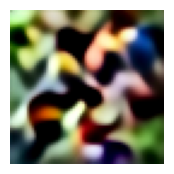

In [96]:
# Load models
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

# Inference Function
def generate_image(prompt):

    # Step 1: Tokenize and encode text
    tokens = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(device)
    with torch.no_grad():
        text_embeddings = text_encoder(**tokens).last_hidden_state

    # Step 2: Generate random noise in latent space
    noise_shape = (1, 3, 64, 64)
    noise = torch.randn(noise_shape).to(device)

    # Step 3: Encode noise to latent space
    with torch.no_grad():
        latents = vae.encode(noise).latent_dist.sample() * 0.18215
                
    # Step 4: Denoise using the UNet
    with torch.no_grad():
        for t in range(config['T']-1, 0, -1):
            # Get the predicted noise from the U-Net
            noise_t = model(latents, torch.tensor([t]).to(device), encoder_hidden_states=text_embeddings, return_dict=False)[0]
            latents = noise_scheduler.step(noise_t, t, latents).prev_sample


    # Step 5: Decode latents to image
    with torch.no_grad():
        latents = 1 / 0.18215 * latents  # Scale back latents
        image = vae.decode(latents).sample

    # Step 6: Convert to PIL image and return
    # image = (image / 2 + 0.5).clamp(0, 1)
    # pil_image = to_pil_image(image[0])
    return image

# Example Usage
generated_image = generate_image(text[1])

from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize=(2,2))
axes.imshow(generated_image.to('cpu')[0].permute(1, 2, 0))
axes.axis('off')
plt.show

text[1]

In [13]:
# from diffusers import AutoencoderKL, UNet2DConditionModel
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import DDPMScheduler

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = torch.load("../saved_models/vae.pth").to(device)
unet = torch.load("../saved_models/diffuser.pth").to(device)
vae.eval()
unet.eval()
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=1e-4, beta_end=0.02)

C:\Users\anike\AppData\Local\Temp\ipykernel_33748\3977206672.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae = torch.load("../saved_models/vae.pth").to(device)
C:\Us

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2905524..1.2319806].


'this flower has a protruding yellow pollen tube surrounded by five large, rounded red petals.\nthis red flower has a red pistil with five red stigmas at the end\nthis flower is vibrant red in color with five petals, and red stigma.\nthis flower has five wide, textured, rounded petals and a prominent pistil which is also of the same color.\nvery wide orange wrinkly petals with one long red stigma and red anthers.\na large red petaled flower with long, red and thin stamen.\nthis red orange flower has rounded petals and a red and yellow pistil.\nthis flower has large and thick red petals with a long red style and red stigma.\nthis flower has petals that are red and has yellow patches\nthis flower is red and yellow in color, and has petals that are pink near the base of the ovary.\n'

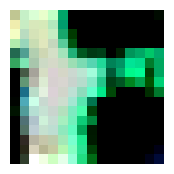

In [ ]:
# Inference Function
def generate_image(prompt):

    # Step 1: Tokenize and encode text
    tokens = tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).to(device)
    with torch.no_grad():
        text_embeddings = text_encoder(**tokens).last_hidden_state

    # Step 2: Generate random noise in latent space
    noise_shape = (1, 3, 16, 16)
    noise = torch.randn(noise_shape).to(device)

    # Step 3: Encode noise to latent space
    with torch.no_grad():
        latents = vae.encode(noise).latent_dist.sample() * 0.18215
                
    # Step 4: Denoise using the UNet
    with torch.no_grad():
        for t in range(1000-1, 0, -1):
            # Get the predicted noise from the U-Net
            noise_t = unet(latents, torch.tensor([t]).to(device), encoder_hidden_states=text_embeddings, return_dict=False)[0]
            latents = noise_scheduler.step(noise_t, t, latents).prev_sample


    # Step 5: Decode latents to image
    with torch.no_grad():
        latents = 1 / 0.18215 * latents  # Scale back latents
        image = vae.decode(latents).sample

    # Step 6: Convert to PIL image and return
    # image = (image / 2 + 0.5).clamp(0, 1)
    # pil_image = to_pil_image(image[0])
    return image

# Example Usage
text = 'this flower has a protruding yellow pollen tube surrounded by five large, rounded red petals.\nthis red flower has a red pistil with five red stigmas at the end\nthis flower is vibrant red in color with five petals, and red stigma.\nthis flower has five wide, textured, rounded petals and a prominent pistil which is also of the same color.\nvery wide orange wrinkly petals with one long red stigma and red anthers.\na large red petaled flower with long, red and thin stamen.\nthis red orange flower has rounded petals and a red and yellow pistil.\nthis flower has large and thick red petals with a long red style and red stigma.\nthis flower has petals that are red and has yellow patches\nthis flower is red and yellow in color, and has petals that are pink near the base of the ovary.\n'
generated_image = generate_image(text)

from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize=(2,2))
axes.imshow(generated_image.to('cpu')[0].permute(1, 2, 0))
axes.axis('off')
plt.show

text

# DEEPSPEED

In [4]:
# Load models
model_name = "openai/clip-vit-large-patch14"
tokenizer = CLIPTokenizer.from_pretrained(model_name)
text_encoder = CLIPTextModel.from_pretrained(model_name).to("cuda")

In [11]:
tokens = tokenizer("Hello", return_tensors="pt", padding="max_length", truncation=True, max_length=77).to("cuda")
with torch.no_grad():
    text_embeddings = text_encoder(**tokens).last_hidden_state
text_embeddings.shape

torch.Size([1, 77, 768])

# VAE

In [2]:
from diffusers import AutoencoderKL
import torch
from glob import glob
from PIL import Image
from torchvision import transforms


c:\Users\anike\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")

In [4]:
images = glob('../data/raw/flowers/images/*.jpg')

In [8]:
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

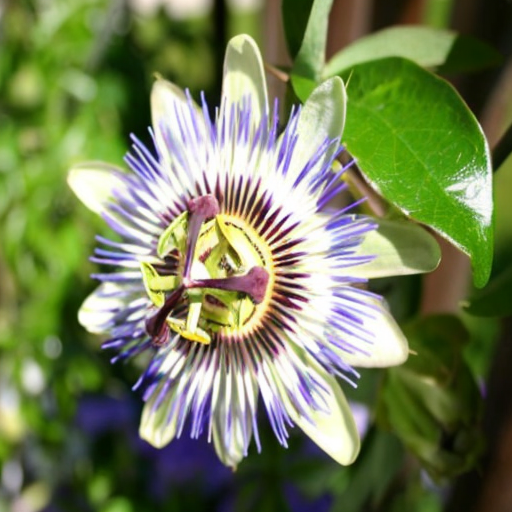

In [14]:
image = Image.open(images[0]).convert("RGB")
image = image_transform(image)
image = (image * 2) - 1
batch = image.unsqueeze(0).cuda().half()

with torch.no_grad():
    latent = vae.encode(batch).latent_dist.sample()
    rec_image = vae.decode(latent).sample

rec_image = ((rec_image + 1 ) / 2.0).clamp(0, 1).cpu().squeeze().permute(1, 2, 0).numpy()
rec_image = (rec_image * 255).astype('uint8')
rec_image = Image.fromarray(rec_image)
rec_image

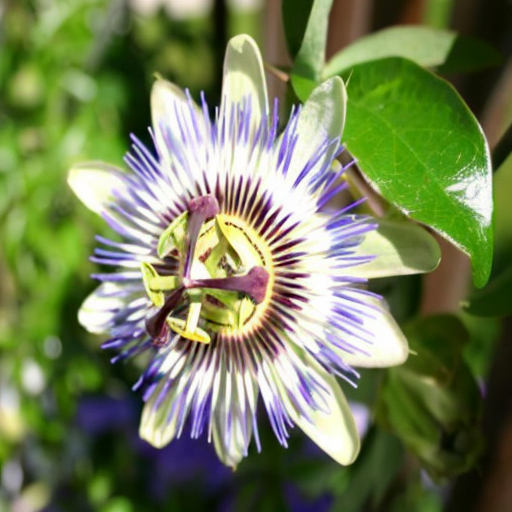

In [15]:
image = Image.open(images[0]).convert("RGB")
image = image_transform(image)
batch = image.unsqueeze(0).cuda().half()

with torch.no_grad():
    latent = vae.encode(batch).latent_dist.sample()
    rec_image = vae.decode(latent).sample

rec_image = rec_image.clamp(0, 1).cpu().squeeze().permute(1, 2, 0).numpy()
rec_image = (rec_image * 255).astype('uint8')
rec_image = Image.fromarray(rec_image)
rec_image